In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# Load data
# ============================================================

CSV_PATH = "zgrab_unified.csv"

df = pd.read_csv(CSV_PATH)
good_df = df.loc[df["success"] == True]

icmp_df = pd.read_csv("icmp.csv")
tcp_df = pd.read_csv("tcp.csv")

# Quick preview
print(df.head())
print(df.shape)
print(good_df.head())
print(good_df.shape)

print(icmp_df.head())

                         ip    asn               prefix country protocol  \
0    2001:19f0:6000:642::33  20473  2001:19f0:6000::/40      US     http   
1    2001:19f0:5c00:1d0::33  20473  2001:19f0:5c00::/40      US     http   
2          2001:1278:9:1::2  18734     2001:1278:9::/48      MX     http   
3  2001:470:1:21::403e:fa0a   6939        2001:470::/32     NaN     http   
4      2001:19f0:0:60c2::33  20473       2001:19f0::/40      US     http   

            server_header device_type  success  
0                     NaN     Unknown    False  
1                     NaN     Unknown    False  
2                     NaN     Unknown    False  
3  Apache/2.4.29 (Ubuntu)      Apache     True  
4                     NaN     Unknown    False  
(23111, 8)
                                        ip    asn               prefix  \
3                 2001:470:1:21::403e:fa0a   6939        2001:470::/32   
6                     2001:470:1:43b:1::72   6939        2001:470::/32   
7               

In [25]:
distinct_good_ips = set(good_df["ip"])
print(len(distinct_good_ips))

2679


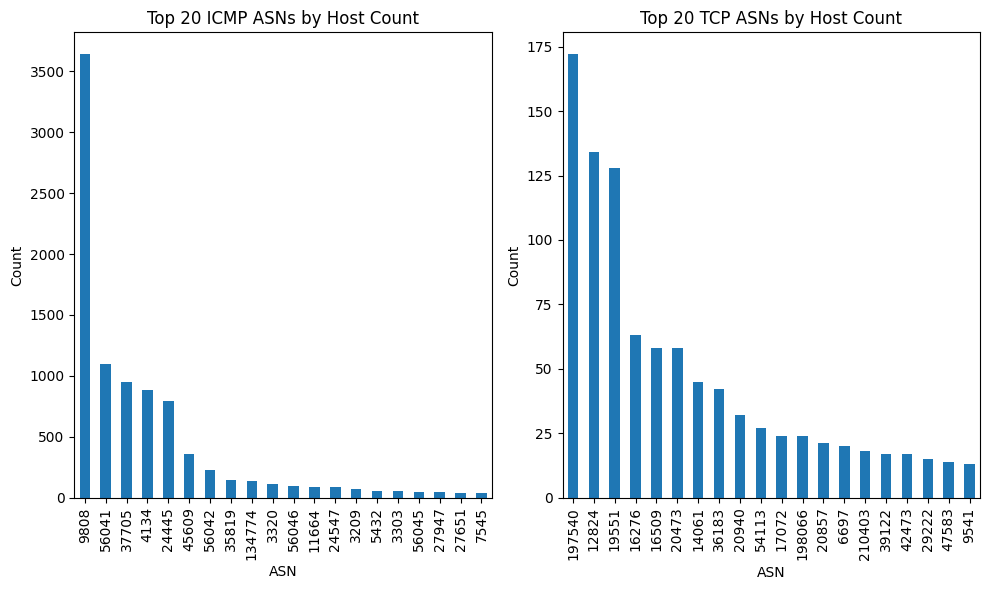

In [ ]:
def plot_top_asns(df, scan_type):
    asns = df['asn'].dropna()

    top_asns = asns.value_counts().head(20)

    top_asns.plot(kind='bar')
    plt.title(f"Top 20 {scan_type} ASNs by Host Count")
    plt.xlabel("ASN")
    plt.ylabel("Count")

plt.figure(figsize=(10,6))

plt.subplot(1, 2, 1)
plot_top_asns(icmp_df, "ICMP")

plt.subplot(1, 2, 2)
plot_top_asns(tcp_df, "TCP")

plt.tight_layout()
plt.show()

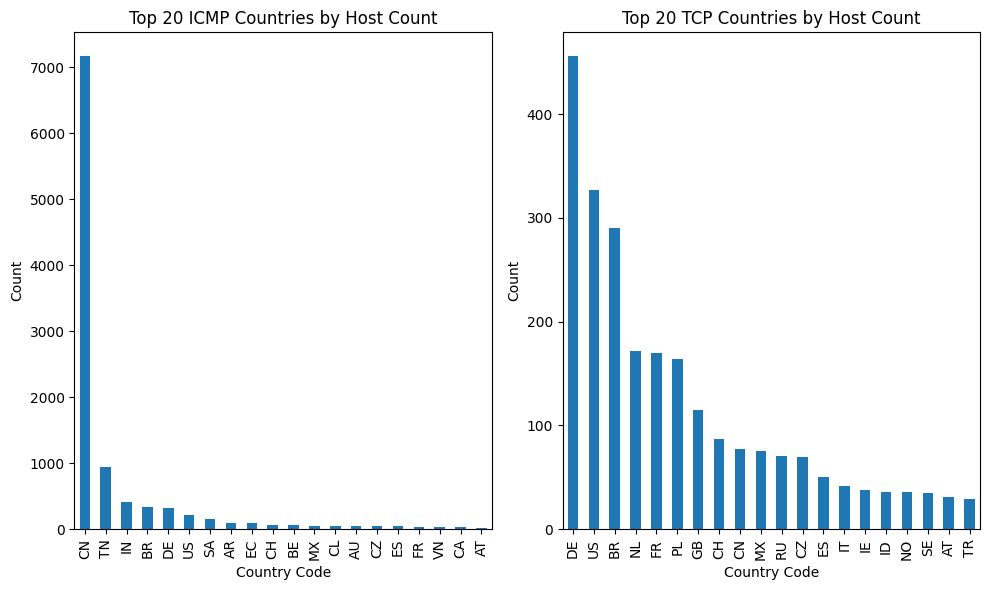

In [15]:
def plot_top_countries(df, scan_type):
    countries = df['country'].dropna()
    top_countries = countries.value_counts().head(20)

    top_countries.plot(kind='bar')
    plt.title(f"Top 20 {scan_type} Countries by Host Count")
    plt.xlabel("Country Code")
    plt.ylabel("Count")

plt.figure(figsize=(10,6))

plt.subplot(1, 2, 1)
plot_top_countries(icmp_df, "ICMP")

plt.subplot(1, 2, 2)
plot_top_countries(tcp_df, "TCP")

plt.tight_layout()
plt.show()

protocol
http      2397
https     1809
ssh        936
ftp        659
imap       451
pop3       431
telnet      24
Name: count, dtype: int64


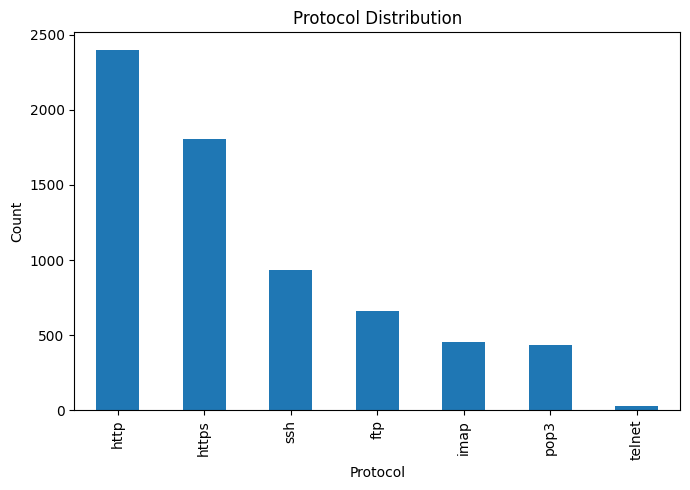

In [24]:
proto_counts = good_df['protocol'].value_counts()
print(proto_counts)

plt.figure(figsize=(7,5))
proto_counts.plot(kind='bar')
plt.title("Protocol Distribution")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

device_type
Nginx            964
Apache           464
Unknown          410
Other            364
Proxygen         118
Akamai            50
Microsoft/IIS     26
Cisco              1
Name: count, dtype: int64


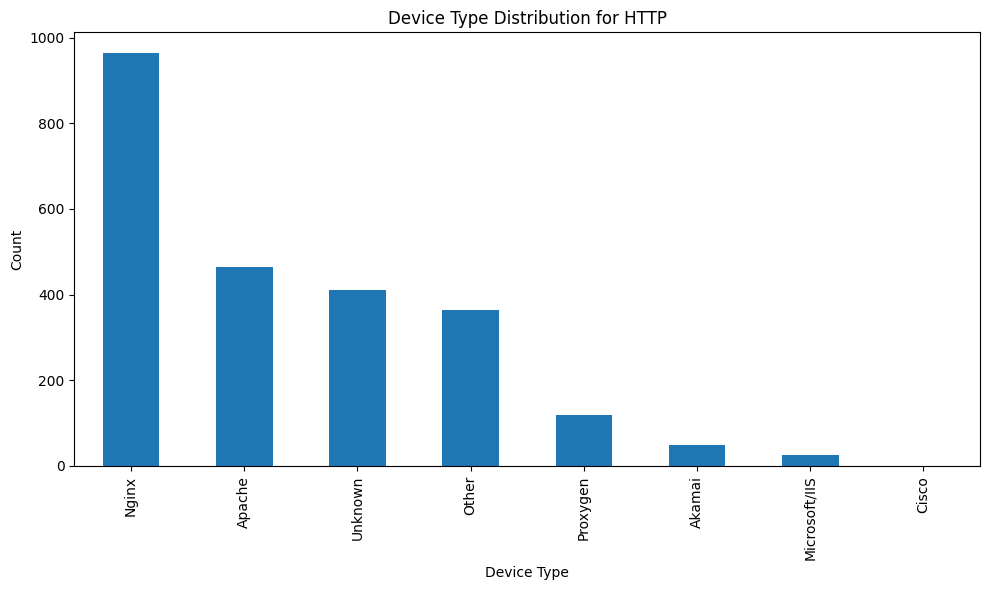

device_type
Nginx              1118
Apache              384
Unknown             171
Other               134
Cloudflare edge       2
Name: count, dtype: int64


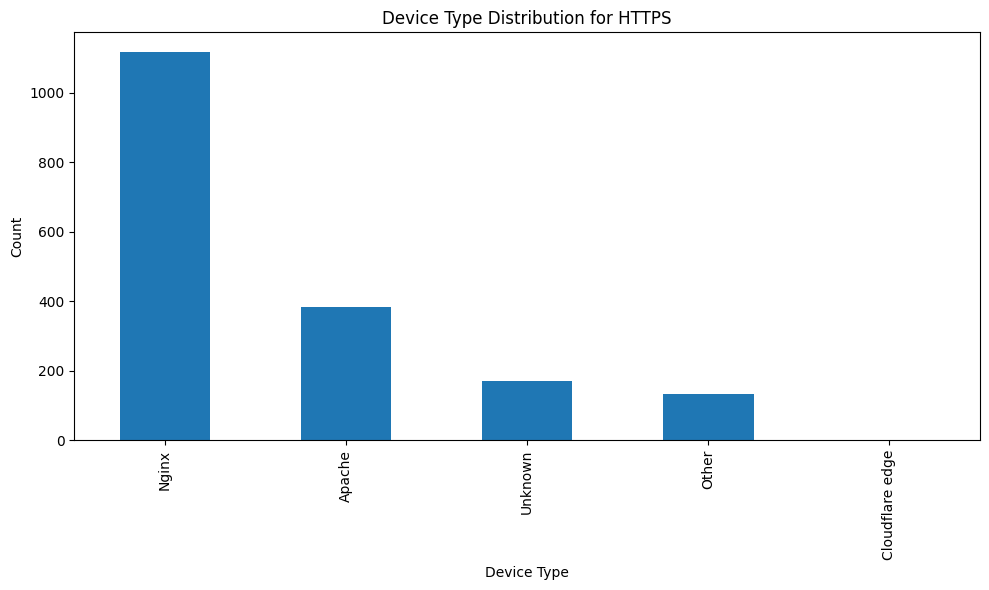

device_type
OpenSSH          871
Cisco             21
Dropbear          21
Other             15
Microsoft/IIS      4
Comware            4
Name: count, dtype: int64


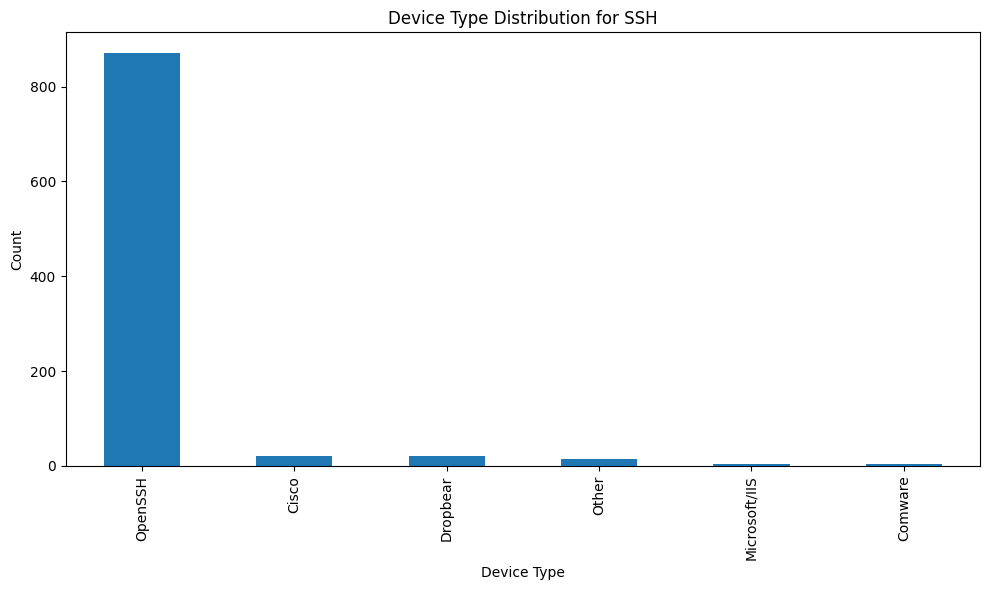

device_type
ProFTPD                295
Pure-FTPd              155
220-Idea FTP Server    134
Other                   75
Name: count, dtype: int64


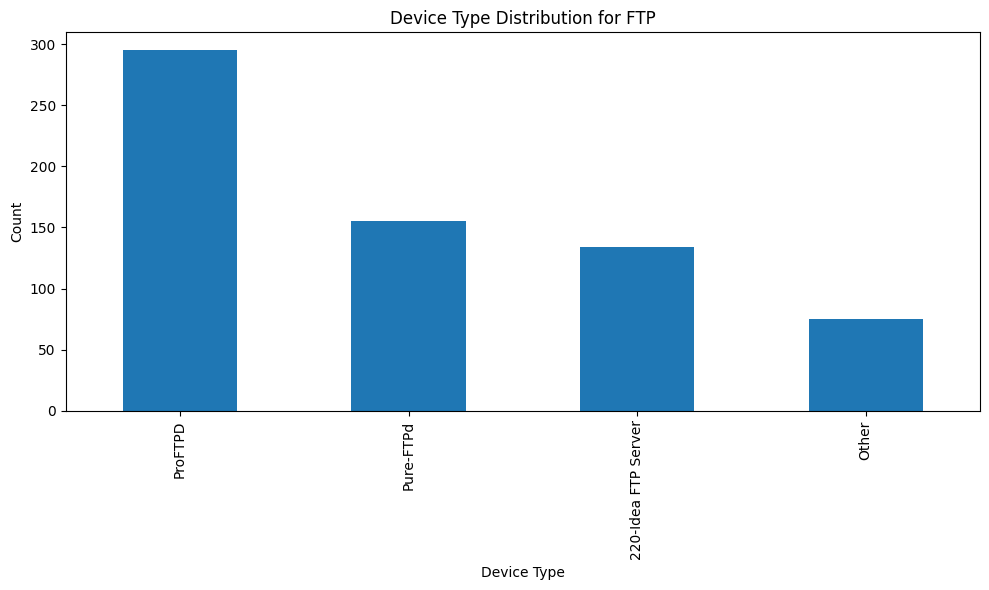

device_type
Dovecot    421
Other       30
Name: count, dtype: int64


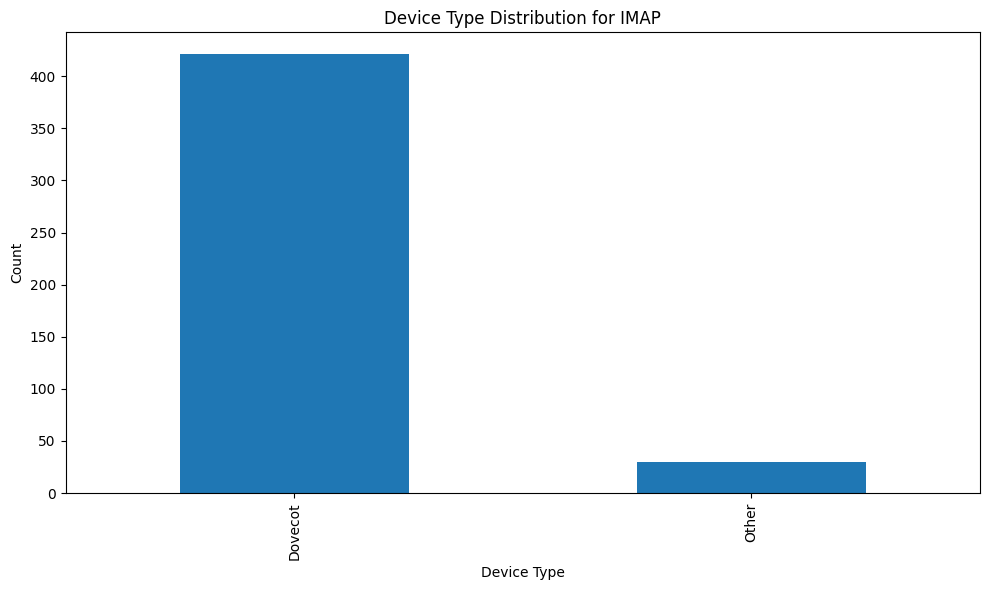

device_type
Dovecot    405
Other       26
Name: count, dtype: int64


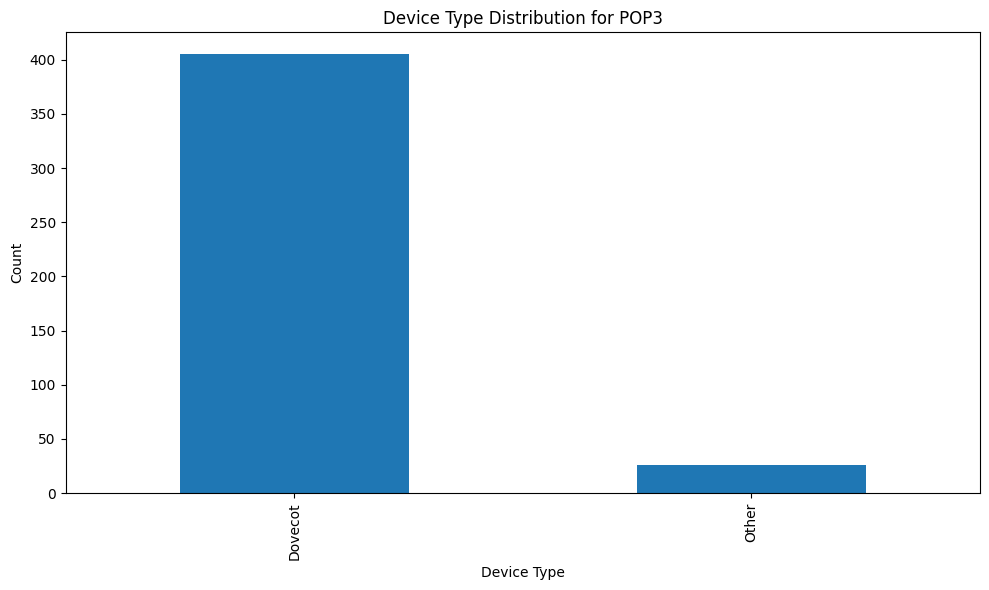

device_type
Other          22
KKeeneticOS     2
Name: count, dtype: int64


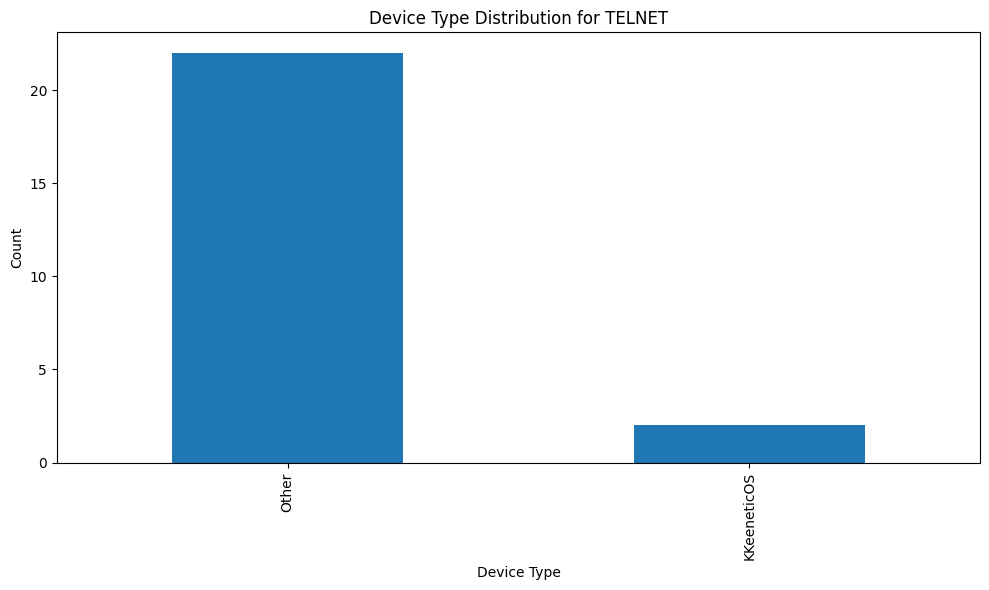

In [32]:
PROTOCOLS = ["http", "https", "ssh", "smtp", "ftp", "imap", "pop3", "telnet"]

for protocol in PROTOCOLS:
    filtered_df = good_df[good_df["protocol"] == protocol]
    if filtered_df.size == 0:
        continue

    device_types = (
        filtered_df['device_type']
        .fillna("Unknown")
        .value_counts()
        .head(20)
    )

    plt.figure(figsize=(10,6))
    print(device_types)
    device_types.plot(kind='bar')
    plt.title(f"Device Type Distribution for {protocol.upper()}")
    plt.xlabel("Device Type")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

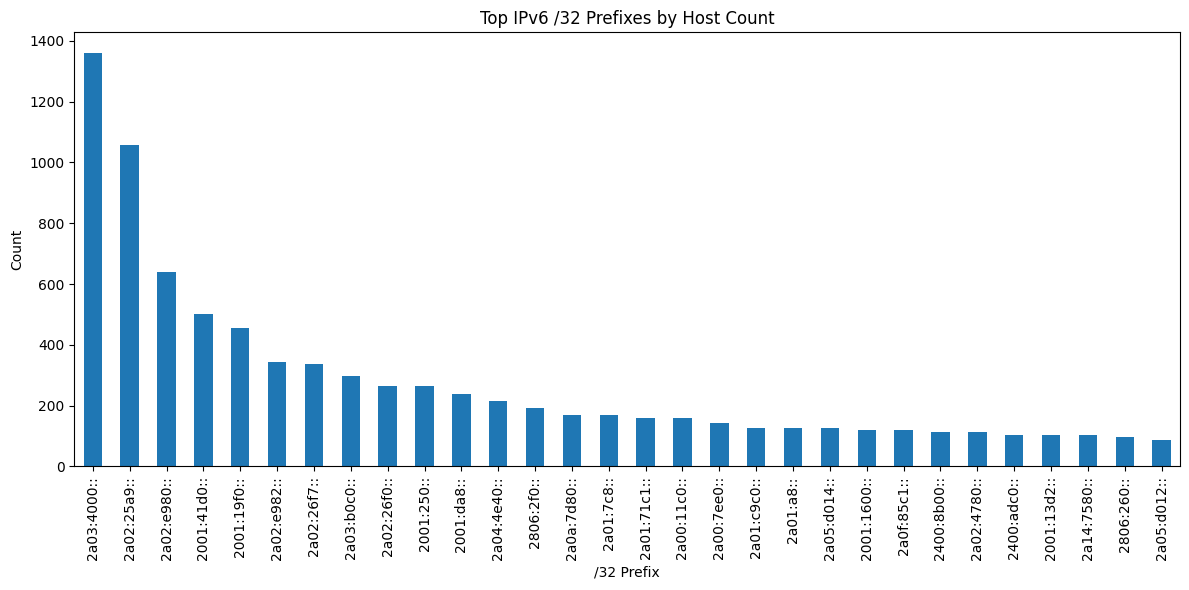

In [30]:
import ipaddress

# Extract /32 prefix from each IPv6 address
def to_32_prefix(ip):
    try:
        network = ipaddress.IPv6Network(ip + "/32", strict=False)
        return str(network.network_address)
    except:
        return None

df['prefix32'] = df['ip'].apply(to_32_prefix)

prefix_counts = df['prefix32'].value_counts().head(30)

plt.figure(figsize=(12,6))
prefix_counts.plot(kind='bar')
plt.title("Top IPv6 /32 Prefixes by Host Count")
plt.xlabel("/32 Prefix")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

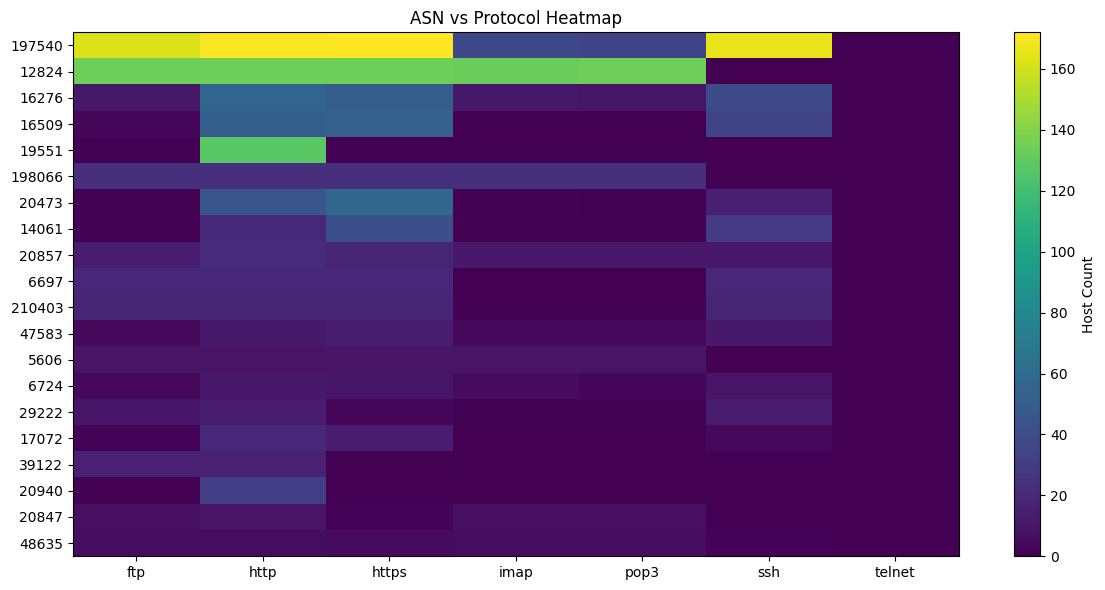

In [20]:
pivot = pd.pivot_table(
    good_df,
    values='ip',
    index='asn',
    columns='protocol',
    aggfunc='count',
    fill_value=0
)

top_asns = pivot.sum(axis=1).sort_values(ascending=False).head(20)
pivot_top = pivot.loc[top_asns.index]

plt.figure(figsize=(12,6))
plt.imshow(pivot_top, aspect='auto')
plt.colorbar(label='Host Count')
plt.xticks(range(len(pivot_top.columns)), pivot_top.columns)
plt.yticks(range(len(pivot_top.index)), pivot_top.index)
plt.title("ASN vs Protocol Heatmap")
plt.tight_layout()
plt.show()

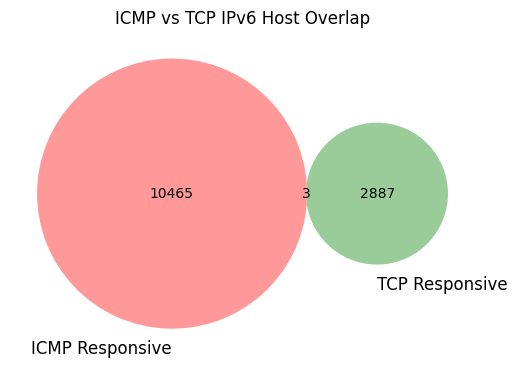

In [22]:
from matplotlib_venn import venn2

icmp_file = open("xmap_addr/icmp.txt", "r")
tcp_file = open("xmap_addr/tcp.txt", "r")

icmp_hosts = set(icmp_file.read().split("\n"))
tcp_hosts = set(tcp_file.read().split("\n"))

plt.figure(figsize=(6,6))
venn2([icmp_hosts, tcp_hosts],
      set_labels=("ICMP Responsive", "TCP Responsive"))
plt.title("ICMP vs TCP IPv6 Host Overlap")
plt.show()

In [23]:
intersection = len(icmp_hosts & tcp_hosts)
union = len(icmp_hosts | tcp_hosts)

jaccard = intersection / union
print("Jaccard Similarity:", jaccard)

Jaccard Similarity: 0.00022463496817671285


In [20]:
def jaccardo(prop):
    icmp_df_prop = set(icmp_df[prop])
    tcp_df_prop = set(tcp_df[prop])

    intersection = len(icmp_df_prop & tcp_df_prop)
    union = len(icmp_df_prop | tcp_df_prop)
    jaccard = intersection / union
    return jaccard

print("Jaccard ASN Similarity:", jaccardo("asn"))
print("Jaccard Country Similarity: ", jaccardo("country"))

Jaccard ASN Similarity: 0.03989637305699482
Jaccard Country Similarity:  0.5877192982456141


In [16]:
def js_distance_from_series(s1, s2):
    dist1 = s1.value_counts().to_dict()
    dist2 = s2.value_counts().to_dict()
    
    return js_distance(dist1, dist2)

def normalize(dist):
    total = sum(dist.values())
    return {k: v / total for k, v in dist.items()}

def js_divergence(p, q):
    keys = sorted(set(p.keys()) | set(q.keys()))
    p_vec = np.array([p.get(k, 0.0) for k in keys])
    q_vec = np.array([q.get(k, 0.0) for k in keys])
    m = 0.5 * (p_vec + q_vec)

    def kl(a, b):
        mask = a > 0
        return np.sum(a[mask] * np.log2(a[mask] / b[mask]))
    
    return 0.5 * kl(p_vec, m) + 0.5 * kl(q_vec, m)

def js_distance(dist1, dist2):
    p = normalize(dist1)
    q = normalize(dist2)
    return np.sqrt(js_divergence(p, q))

In [18]:
js = js_distance_from_series(icmp_df["asn"], tcp_df["asn"])
print("ASN JSD ICMP vs TCP:", js)

js = js_distance_from_series(icmp_df["country"], tcp_df["country"])
print("Country JSD ICMP vs TCP:", js)

ASN JSD ICMP vs TCP: 0.9812487192659094
Country JSD ICMP vs TCP: 0.7821043899940331
